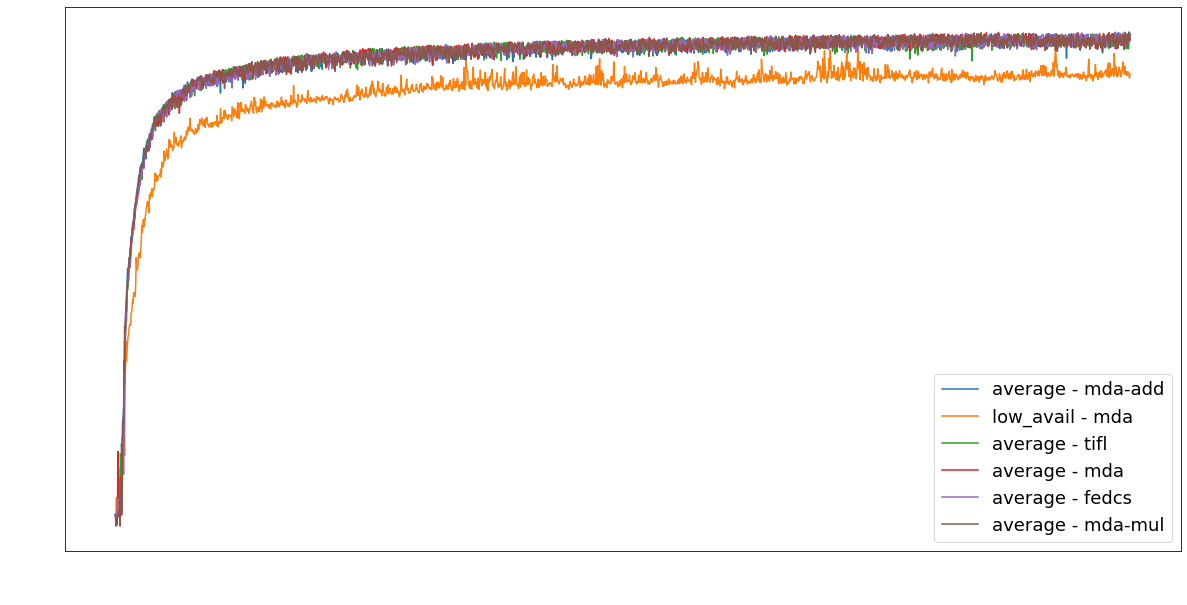

,average - mda-add,low_avail - mda,average - tifl,average - mda,average - fedcs,average - mda-mul
finish_time,230133.302599,249447.063477,94330.909163,248605.038202,124949.684525,223528.944304
mean_acc,0.839602,0.782702,0.837924,0.840225,0.839166,0.839650
std_acc,0.006715,0.006984,0.007173,0.006510,0.007302,0.006714
avg_failed,0.086000,0.115000,0.076000,0.106000,0.080000,0.109500
rounds_failed,160.000000,214.000000,150.000000,203.000000,154.000000,204.000000
unique_participants,2728.000000,1779.000000,2381.000000,2767.000000,2047.000000,2697.000000


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import pandas as pd
import ast

plt.rcParams.update({
    'font.size': 18,
    'text.color': 'black',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white'
})
plt.figure(figsize=(20, 10))

data = {}


def extract_file_data(file):
    with open(file) as file:
        raw = file.read()
        failed = re.compile('Round \d+ failed clients: (\[[^]]*])').findall(raw)
        failed = list(map(len, map(ast.literal_eval, failed)))
        avg_failed = np.mean(failed)
        rounds_failed = len(list(filter(lambda x: x > 0, failed)))
        selected = re.compile('Sampled clients for round \d+: (\[[^]]*])').findall(raw)
        selected = list(map(ast.literal_eval, selected))
        unique_participants = len(set().union(*selected))
        return avg_failed, unique_participants, rounds_failed


for dir in os.listdir('results'):
    config = ''
    with open('results/' + dir + '/args.txt') as args:
        args = args.read()
        config = re.compile('trace_distro = (\S+)').search(args).group(1)
        config += ' - ' + re.compile('selector = (\S+)').search(args).group(1)
        if 'mda' in config and 'score_method' in args:
            config += '-' + re.compile('score_method = (\S+)').search(args).group(1)

    accuracies = np.load('results/' + dir + '/accuracies.npy')
    for file in os.listdir('results/' + dir):
        if file.startswith('run.sh'):
            avg_failed, unique_participants, rounds_failed = extract_file_data('results/' + dir + '/' + file)

    plt.plot(range(len(accuracies)), accuracies, label=config)
    times = np.load('results/' + dir + '/times.npy')
    data[config] = {
        'finish_time': times[-1],
        'mean_acc': accuracies[1500:].mean(),
        'std_acc': accuracies[1500:].std(),
        'avg_failed': avg_failed,
        'rounds_failed': rounds_failed,
        'unique_participants': unique_participants
    }

plt.xlabel('Round number')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

pd.DataFrame(data)